<h1>Chapter 5 | Data Exercise #1 | Financial Assets | Generalizing from Data</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 1</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>1. Download ten years of daily data on the price of a financial asset, such as an individual stock, or another stock market index.</p>
<p>Assignments:</p>
<ul>
    <li>Document the main features of the data.</li>
    <li>Create daily percentage returns.</li>
    <li>Create a binary variable indicating large losses by choosing your own cutoff.</li>
    <li>Estimate the standard error of the estimated likelihood of large daily losses by bootsrap and using the SE formula.</li>
    <li>Compare the two, and create 95% confidence intervals.</li>
    <li>Conclude by giving advice on how to use these results in future investments decisions.</li>

</ul>
<h2>1. Load the data</h2>

In [44]:
import os
import pandas as pd
import warnings
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

In [22]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [23]:
# Current script folder
dirname = os.getcwd()

# Get location folders
data_in = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/raw/"
data_out = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/clean/"
output = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/output/"
func = f"{dirname}da_case_studies/ch00-tech_prep/"

paths = [data_in, data_out, output]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

It would be a good idea to see how Brazilian firms are doing. We could use **Petrobras**, the main Brazilian oil company (which is a state-owned multinational corporation). Let's test using `Yahoo Finance`.

In [24]:
ticker = yf.Ticker("PETR4.SA")

# Get data of the most recent date
petr4_data = ticker.history(period="5d")

petr4_data


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-01 00:00:00-03:00,38.310001,38.759998,38.180000,38.630001,24963500,0.0,0.0
2024-07-02 00:00:00-03:00,38.830002,39.099998,38.439999,38.509998,33346200,0.0,0.0
2024-07-03 00:00:00-03:00,38.700001,38.790001,37.759998,37.840000,38509400,0.0,0.0
2024-07-04 00:00:00-03:00,37.900002,37.959999,37.119999,37.320000,32698800,0.0,0.0
2024-07-05 00:00:00-03:00,37.450001,37.650002,37.110001,37.520000,32758800,0.0,0.0


Great! Now, our goal is to get 10 years of data. Let's try to specify the period we want and hopefully this API won't let us down.

In [25]:
# Define the start date
start_date = datetime(2014, 7, 7)

# Define the end date
end_date = datetime(2024, 7, 7)

# Pass the parameters as the taken dates for start and end
petr4_data = yf.Ticker("PETR4.SA")
petr4_df = petr4_data.history(start=start_date, end=end_date)

In [26]:
petr4_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-07-07 00:00:00-03:00,5.747406,5.757310,5.658273,5.717695,18701200,0.0,0.0
2014-07-08 00:00:00-03:00,5.730901,5.750708,5.668178,5.720997,11504900,0.0,0.0
2014-07-10 00:00:00-03:00,5.869553,5.998300,5.816733,5.978493,35913600,0.0,0.0
2014-07-11 00:00:00-03:00,5.965287,6.047817,5.876154,6.021408,20928900,0.0,0.0
2014-07-14 00:00:00-03:00,6.100636,6.331721,6.080829,6.305312,70399100,0.0,0.0


Jah bless Yahoo Finance! Let's move on.
## 2. Document the main features of the data ##
Let's take a picture of our dataset and describe it.



In [27]:
petr4_df.shape

(2488, 7)

In [28]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2488 entries, 2014-07-07 00:00:00-03:00 to 2024-07-05 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2488 non-null   float64
 1   High          2488 non-null   float64
 2   Low           2488 non-null   float64
 3   Close         2488 non-null   float64
 4   Volume        2488 non-null   int64  
 5   Dividends     2488 non-null   float64
 6   Stock Splits  2488 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 155.5 KB


In [29]:
is_duplicate = petr4_df.duplicated().sum()
print(f"There are {is_duplicate} observations in the dataset.")

There are 0 observations in the dataset.


A brief summary:
- Our dataset has 2488 observations and 7 features/variables.
- All columns are numeric.
- There are no missing values.
- There are no duplicate values either.

About the variables, a short description:


| **Variable** | **Definition** |
|--------------| ---------------|
| `Open`       | The opening price for the specified date. |
| `High`       | The high price for the specified date. |
| `Low`        | The low price for the specified date. |
| `Close`      | The closing price for the specified date. |
| `Volume`     | The number of shares traded in a stock or contracts traded in futures or options. |
| `Dividends`  | A portion of a company's earnings that is paid to a shareholder. |
| `Stock Splits` |  A corporate action in which a company increases the number of its outstanding shares by issuing more shares to current shareholders. | 


## 3. Create daily percentage returns and date columns##
Our goal is to work on closing prices, so we can include only `Close` and create a percent return variable that indicate the percentage change on a daily basis.


In [36]:
# Keep only `Close` column
petr4_df = petr4_df[["Close"]]

petr4_df["pct_return"] = (
    (petr4_df["Close"] - petr4_df.shift(1)["Close"])
    /
    petr4_df.shift(1)["Close"] * 100
)

In [39]:
petr4_df.head()

,Close,pct_return
Date,,
2014-07-07 00:00:00-03:00,5.717695,NaN
2014-07-08 00:00:00-03:00,5.720997,0.057752
2014-07-10 00:00:00-03:00,5.978493,4.500892
2014-07-11 00:00:00-03:00,6.021408,0.717821
2014-07-14 00:00:00-03:00,6.305312,4.714912


In [40]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2488 entries, 2014-07-07 00:00:00-03:00 to 2024-07-05 00:00:00-03:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       2488 non-null   float64
 1   pct_return  2487 non-null   float64
dtypes: float64(2)
memory usage: 58.3 KB


In [41]:
# Convert the `Date` index to a column
petr4_df.reset_index(inplace=True)
petr4_df.head()

,Date,Close,pct_return
0,2014-07-07 00:00:00-03:00,5.717695,NaN
1,2014-07-08 00:00:00-03:00,5.720997,0.057752
2,2014-07-10 00:00:00-03:00,5.978493,4.500892
3,2014-07-11 00:00:00-03:00,6.021408,0.717821
4,2014-07-14 00:00:00-03:00,6.305312,4.714912


Great! We can now perform a few transformations on `Date` and obtain the separate `year`, `month`, and `yearmonth` variables.

In [42]:
petr4_df["Date"] = pd.to_datetime(petr4_df["Date"], format="%Y-%m-%d")
petr4_df["year"] = petr4_df["Date"].dt.year
petr4_df["month"] = petr4_df["Date"].dt.month
petr4_df["year_month"] = petr4_df["Date"].dt.to_period("M")


In [43]:
petr4_df.head()

,Date,Close,pct_return,year,month,year_month
0,2014-07-07 00:00:00-03:00,5.717695,NaN,2014,7,2014-07
1,2014-07-08 00:00:00-03:00,5.720997,0.057752,2014,7,2014-07
2,2014-07-10 00:00:00-03:00,5.978493,4.500892,2014,7,2014-07
3,2014-07-11 00:00:00-03:00,6.021408,0.717821,2014,7,2014-07
4,2014-07-14 00:00:00-03:00,6.305312,4.714912,2014,7,2014-07


## 4. Plot the histogram of daily returns, annotate losses ##

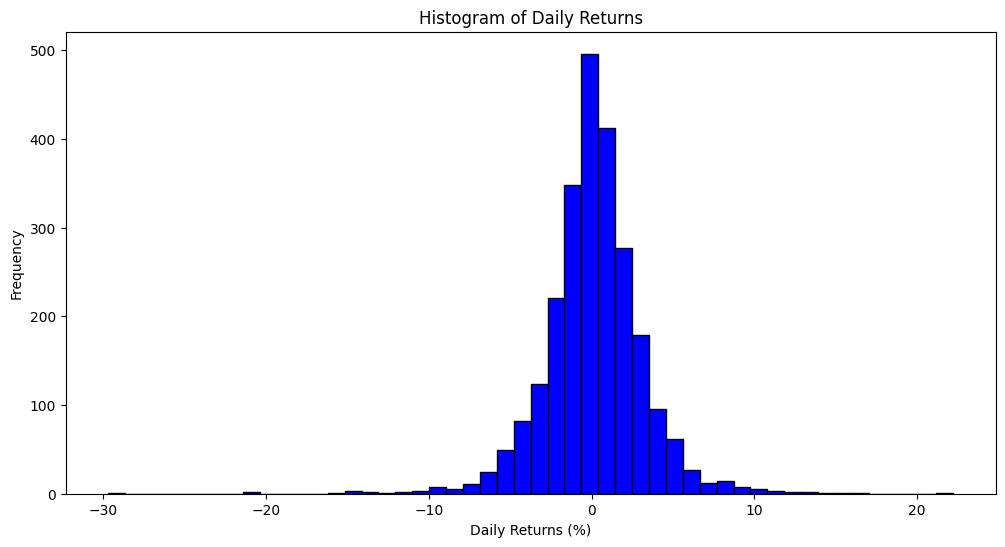

In [45]:
# Create histogram of daily returns
plt.figure(figsize=(12, 6))

plt.hist(petr4_df["pct_return"], bins=50, color="blue", edgecolor="black")
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Returns (%)")
plt.ylabel("Frequency")
plt.show()
